<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Financial Data Science &mdash; IO Operations

**DataNatives Berlin 2015**

Dr Yves J Hilpisch

<a href='mailto:team@tpq.io'>team@tpq.io</a> | <a href='http://tpq.io'>http://tpq.io</a>

The Python Quants GmbH

## TsTables &ndash; High Performance Times Series Management

**TsTables** is a Python library by Andy Fiedler built on top of the popular ``PyTables`` HDF5 database library. It is meant to handle large amounts of **high frequency time series data** in **append once, retrieve many times** scenarios (cf. [Gihub page](https://github.com/afiedler/tstables)). The focus lies on retrieving chunks of data from large data sets as quickly as possible.

In [1]:
import numpy as np
import pandas as pd
import tables as tb
import tstables as tstb
import random
from time import time
from datetime import datetime 
%matplotlib inline
import seaborn as sns
sns.set()

### Sample Time Series Data

Let us generate a **decent amount of sample data points**.

In [2]:
no = 10000000
co = 3
dt = 1. / (12 * 30 * 24 * 60)
vol = 0.2

We generate **one second intervals** of data.

In [3]:
dr = pd.date_range('2015-1-1', periods=no, freq='1s')

In [4]:
dr

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 00:00:01',
               '2015-01-01 00:00:02', '2015-01-01 00:00:03',
               '2015-01-01 00:00:04', '2015-01-01 00:00:05',
               '2015-01-01 00:00:06', '2015-01-01 00:00:07',
               '2015-01-01 00:00:08', '2015-01-01 00:00:09',
               ...
               '2015-04-26 17:46:30', '2015-04-26 17:46:31',
               '2015-04-26 17:46:32', '2015-04-26 17:46:33',
               '2015-04-26 17:46:34', '2015-04-26 17:46:35',
               '2015-04-26 17:46:36', '2015-04-26 17:46:37',
               '2015-04-26 17:46:38', '2015-04-26 17:46:39'],
              dtype='datetime64[ns]', length=10000000, freq='S')

**In memory** generation is quite quick.

In [5]:
%%time
da = 100 * np.exp(np.cumsum(-0.5 * vol ** 2 * dt +
        vol * np.sqrt(dt) * np.random.standard_normal((no, co)), axis=0))
da[0] = 100

CPU times: user 2.11 s, sys: 534 ms, total: 2.65 s
Wall time: 2.66 s


In [6]:
df = pd.DataFrame(da, index=dr, columns=['ts1', 'ts2', 'ts3'])

In [7]:
df.count()

ts1    10000000
ts2    10000000
ts3    10000000
dtype: int64

The **starting values** of the three time series.

In [8]:
df.head()

,ts1,ts2,ts3
2015-01-01 00:00:00,100.000000,100.000000,100.000000
2015-01-01 00:00:01,100.055616,100.025013,99.981646
2015-01-01 00:00:02,100.103041,100.042280,99.989934
2015-01-01 00:00:03,100.089862,100.069699,100.030886
2015-01-01 00:00:04,100.097185,100.045774,100.076647


And a **plot** of the time series data (every 200000th point).

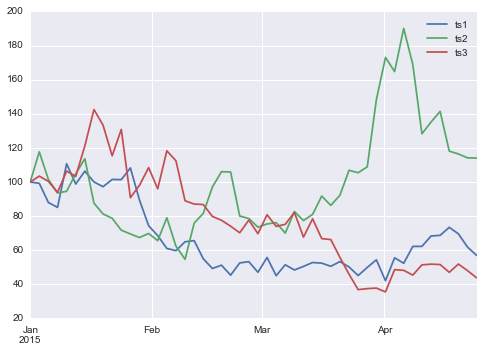

In [9]:
df[::200000].plot()

### Storage and Retrieval with TsTables

To store the time series data in a **PyTables table** we first define the **table structure**.

In [10]:
class TS(tb.IsDescription):
    timestamp = tb.Int64Col(pos=0)
    ts1 = tb.Float64Col(pos=1)
    ts2 = tb.Float64Col(pos=2)
    ts3 = tb.Float64Col(pos=3)

Second, open a database file and **create the table object**.

In [11]:
h5 = tb.open_file('ts.h5','w')

TsTables adds a new function **``create_ts``** to PyTables.

In [12]:
ts = h5.create_ts('/','TS', TS)

Third, we **append the time series data** to the table object.

In [13]:
%time ts.append(df)

CPU times: user 1.53 s, sys: 1.86 s, total: 3.39 s
Wall time: 4.24 s


In [14]:
ls -n *.h5

-rw-r--r--  1 501  20  299446720 Nov 19 17:46 ts.h5


The **approach** of ``TsTables`` is to apply a **highly structured storage** hierarchy.

In [15]:
a = str(h5)
print a[:508]

ts.h5 (File) ''
Last modif.: 'Thu Nov 19 17:46:52 2015'
Object Tree: 
/ (RootGroup) ''
/TS (Group/Timeseries) ''
/TS/y2015 (Group) ''
/TS/y2015/m01 (Group) ''
/TS/y2015/m02 (Group) ''
/TS/y2015/m03 (Group) ''
/TS/y2015/m04 (Group) ''
/TS/y2015/m11 (Group) ''
/TS/y2015/m11/d19 (Group) ''
/TS/y2015/m11/d19/ts_data (Table(0,)) ''
/TS/y2015/m04/d01 (Group) ''
/TS/y2015/m04/d01/ts_data (Table(86400,)) ''
/TS/y2015/m04/d02 (Group) ''
/TS/y2015/m04/d02/ts_data (Table(86400,)) ''
/TS/y2015/m04/d03 (Group) ''
/T


The strength of TsTables lies in retrieving **chunks of time series data** defined by a **start date and an end date** (which obviously is a typical case in finance, e.g. in backtesting strategies or risk management).

In [16]:
read_start_dt = datetime(2015, 2, 1, 0, 0)
read_end_dt = datetime(2015, 2, 2, 0, 0)

TsTables tries to make such an operation **as fast as possible**.

In [17]:
%time rows = ts.read_range(read_start_dt, read_end_dt)

CPU times: user 31.4 ms, sys: 27.7 ms, total: 59.1 ms
Wall time: 46.3 ms


Let us try it with **random intervals**.

In [18]:
t0 = time()
its = 100
for _ in xrange(its):
    day = random.randint(1, 27)
    read_start_dt = datetime(2015, 2, day, 0, 0)
    read_end_dt = datetime(2015, 2, day + 1, 0, 0)
    rows = ts.read_range(read_start_dt, read_end_dt)
t1 = time()

The **results** are convincing.

In [19]:
print "time for %d random accesses    %5.3f seconds" %(its, t1 - t0)
print "average time for random access  %5.3f seconds" %((t1 - t0) / its)

time for 100 random accesses    1.528 seconds
average time for random access  0.015 seconds


Conveniently, the **returned object is a pandas DataFrame**.

In [20]:
rows.count()

ts1    86401
ts2    86401
ts3    86401
dtype: int64

In [21]:
rows.head()

,ts1,ts2,ts3
2015-02-16 00:00:00,50.698230,101.366495,82.635171
2015-02-16 00:00:01,50.692724,101.406572,82.639057
2015-02-16 00:00:02,50.700773,101.378886,82.605793
2015-02-16 00:00:03,50.692889,101.396351,82.562722
2015-02-16 00:00:04,50.683953,101.381599,82.547240


A look at a **data sub-set**.

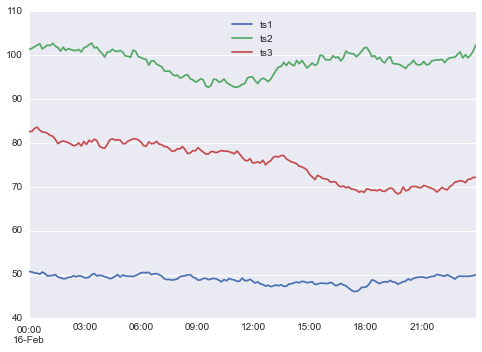

In [22]:
rows[::500].plot()

In [23]:
h5.close()

In [24]:
!rm ts.h5

## bcolz &ndash; High Performance Columnar Data Store

`bcolz` is a **columnar data store** for fast data storage and retrieval with built-in **high performance compression**. It supports both **in-memory and out-of-memory** storage and operations. Cf. <a href="http://bcolz.blosc.org/" target="_blank">http://bcolz.blosc.org/</a>.

In [25]:
import bcolz

## ctable Example 

The first example is based on the ``ctable`` class for data in **table format**. The example data set is **100+ MB** in size.

In [26]:
N = 100000 * 100
print N

10000000


### In-Memory Storage

We generate first an **in-memory object** using high compression. Since we work with integers, **good compression ratios** are to be expected. It takes about **4 sec** to generate the ``ctable`` object from a generator via the ``fromiter`` method.

In [27]:
%%time
ct = bcolz.fromiter(((i, i ** 2) for i in xrange(N)),
                    dtype="i4, i8",
                    count=N,
                    cparams=bcolz.cparams(clevel=9))

CPU times: user 3.89 s, sys: 156 ms, total: 4.04 s
Wall time: 3.98 s


The **in-memory size** is about **15 MB** only, which translates in to a **compression ratio of 7+**.

In [28]:
ct

ctable((10000000,), [('f0', '<i4'), ('f1', '<i8')])
  nbytes: 114.44 MB; cbytes: 15.51 MB; ratio: 7.38
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
[(0, 0) (1, 1) (2, 4) ..., (9999997, 99999940000009)
 (9999998, 99999960000004) (9999999, 99999980000001)]

You can now implement **fast numerical operations** on this data object (note that the output is a ``carray`` object).

In [29]:
%time ct.eval('f0 ** 2 + sqrt(f1)')

CPU times: user 677 ms, sys: 126 ms, total: 803 ms
Wall time: 370 ms


carray((10000000,), float64)
  nbytes: 76.29 MB; cbytes: 30.63 MB; ratio: 2.49
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[  0.00000000e+00   2.00000000e+00   6.00000000e+00 ...,   2.26447238e+08
   2.46447234e+08   2.66447232e+08]

### Disk-Based Storage

The same tasks can be implemented with **disk-based storage**. To this end, only specify the **``rootdir`` parameter**. With about **5 sec** the generation takes a bit longer on disk. everything else (especially the object handling) remaining the same however.

In [30]:
%%time
ct = bcolz.fromiter(((i, i ** 2) for i in xrange(N)),
                    dtype="i4, i8",
                    count=N, rootdir='ct',
                    cparams=bcolz.cparams(clevel=9))

CPU times: user 4.38 s, sys: 170 ms, total: 4.55 s
Wall time: 4.45 s


Everything else (especially the object handling) **remains almost the same** however.

In [31]:
ct

ctable((10000000,), [('f0', '<i4'), ('f1', '<i8')])
  nbytes: 114.44 MB; cbytes: 15.51 MB; ratio: 7.38
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
  rootdir := 'ct'
[(0, 0) (1, 1) (2, 4) ..., (9999997, 99999940000009)
 (9999998, 99999960000004) (9999999, 99999980000001)]

The **numerical operations work in the same fashion** and hardly take longer due to native **multi threading and optimized caching**.

In [32]:
%time ct.eval('f0 ** 2 + sqrt(f1)')

CPU times: user 670 ms, sys: 136 ms, total: 807 ms
Wall time: 335 ms


carray((10000000,), float64)
  nbytes: 76.29 MB; cbytes: 30.63 MB; ratio: 2.49
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[  0.00000000e+00   2.00000000e+00   6.00000000e+00 ...,   2.26447238e+08
   2.46447234e+08   2.66447232e+08]

Let us finally verify **system disk usage**.

In [33]:
!ls ct

__attrs__    __rootdirs__ f0           f1


In [34]:
!du -h ct
# system disk usage

612K	ct/f0/data
8.0K	ct/f0/meta
624K	ct/f0
 14M	ct/f1/data
8.0K	ct/f1/meta
 14M	ct/f1
 15M	ct


In [35]:
!rm -r ct

## carray Example

This example is about **mid data** which does **not fit (in general) into memory** (without compression). 

In [36]:
import numpy as np

We generte as basis a NumPy ``ndarray`` object of size **32 MB**.

In [37]:
n = 2000
a = np.arange(n * n).reshape(n, n) 
a.nbytes

32000000

### In-Memory Storage

Let us first again work **in-memory**. Our ``carray`` object contains **400 versions** of the ``ndarray`` object. The in-memory generation of the object takes about **5 sec**.

In [38]:
%%time
it = 400
ca = bcolz.carray(a, cparams=bcolz.cparams(clevel=9))
for i in range(it):
    ca.append(a)

CPU times: user 5.05 s, sys: 195 ms, total: 5.25 s
Wall time: 5.22 s


The ``carray`` object stores **12 GB** worth of data in less than **0.1 GB** of memory, for a compression ratio of more than  **130**.

In [39]:
ca

carray((802000, 2000), int64)
  nbytes: 11.95 GB; cbytes: 91.86 MB; ratio: 133.22
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
[[      0       1       2 ...,    1997    1998    1999]
 [   2000    2001    2002 ...,    3997    3998    3999]
 [   4000    4001    4002 ...,    5997    5998    5999]
 ..., 
 [3994000 3994001 3994002 ..., 3995997 3995998 3995999]
 [3996000 3996001 3996002 ..., 3997997 3997998 3997999]
 [3998000 3998001 3998002 ..., 3999997 3999998 3999999]]

Let us implement the **evaluation of a numerical expression** on this data set. The syntax and handling are the same **as with NumPy ``ndarray`` objects**. 

In [40]:
%time ca[:5000] ** 2 + np.sqrt(ca[10000:15000])

CPU times: user 214 ms, sys: 134 ms, total: 348 ms
Wall time: 339 ms


array([[  0.00000000e+00,   2.00000000e+00,   5.41421356e+00, ...,
          3.98805369e+06,   3.99204870e+06,   3.99604571e+06],
       [  4.00004472e+06,   4.00404573e+06,   4.00804874e+06, ...,
          1.59760722e+07,   1.59840672e+07,   1.59920642e+07],
       [  1.60000632e+07,   1.60080643e+07,   1.60160673e+07, ...,
          3.59640864e+07,   3.59760814e+07,   3.59880785e+07],
       ..., 
       [  3.97603600e+12,   3.97603999e+12,   3.97604398e+12, ...,
          3.98400403e+12,   3.98400802e+12,   3.98401201e+12],
       [  3.98401600e+12,   3.98401999e+12,   3.98402399e+12, ...,
          3.99199201e+12,   3.99199601e+12,   3.99200001e+12],
       [  3.99200400e+12,   3.99200800e+12,   3.99201199e+12, ...,
          3.99998800e+12,   3.99999200e+12,   3.99999600e+12]])

Another approach is to use the **``eval`` function** of bcolz.

In [41]:
x = ca[:10000]  # 10,000 rows as sub-set

In [42]:
%time bcolz.eval('x ** 2 + sqrt(x)', cparams=bcolz.cparams(clevel=9))
  # output carray object compressed

CPU times: user 1.03 s, sys: 127 ms, total: 1.16 s
Wall time: 376 ms


carray((10000, 2000), float64)
  nbytes: 152.59 MB; cbytes: 38.70 MB; ratio: 3.94
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
[[  0.00000000e+00   2.00000000e+00   5.41421356e+00 ...,   3.98805369e+06
    3.99204870e+06   3.99604571e+06]
 [  4.00004472e+06   4.00404573e+06   4.00804874e+06 ...,   1.59760722e+07
    1.59840672e+07   1.59920642e+07]
 [  1.60000632e+07   1.60080643e+07   1.60160673e+07 ...,   3.59640864e+07
    3.59760814e+07   3.59880785e+07]
 ..., 
 [  1.59520360e+13   1.59520440e+13   1.59520520e+13 ...,   1.59679920e+13
    1.59680000e+13   1.59680080e+13]
 [  1.59680160e+13   1.59680240e+13   1.59680320e+13 ...,   1.59839800e+13
    1.59839880e+13   1.59839960e+13]
 [  1.59840040e+13   1.59840120e+13   1.59840200e+13 ...,   1.59999760e+13
    1.59999840e+13   1.59999920e+13]]

### Disk-Based Storage

**Disk-based storage** of multiple versions of the array object. We write the object **400 times** to disk in a **single ``carray`` object**. It takes only about **0.1 mins** to compress and store **12 GB** worth of data **on disk**.

In [43]:
%%time
it = 400
ca = bcolz.carray(a, rootdir='ca',
                 cparams=bcolz.cparams(clevel=9))
for i in range(it):
    ca.append(a)

CPU times: user 8.09 s, sys: 6.67 s, total: 14.8 s
Wall time: 15 s


The **compression ratio** in this case is again **130+**.

In [44]:
ca

carray((802000, 2000), int64)
  nbytes: 11.95 GB; cbytes: 91.86 MB; ratio: 133.22
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
  rootdir := 'ca'
  mode    := 'a'
[[      0       1       2 ...,    1997    1998    1999]
 [   2000    2001    2002 ...,    3997    3998    3999]
 [   4000    4001    4002 ...,    5997    5998    5999]
 ..., 
 [3994000 3994001 3994002 ..., 3995997 3995998 3995999]
 [3996000 3996001 3996002 ..., 3997997 3997998 3997999]
 [3998000 3998001 3998002 ..., 3999997 3999998 3999999]]

**Simple numerical operations** are easy to implement.

In [45]:
%time np.sum(ca[:1000] + ca[4000:5000])

CPU times: user 41.6 ms, sys: 29.1 ms, total: 70.6 ms
Wall time: 67.3 ms


3999998000000

Let us try the previous, **mathematically more demanding operation** &ndash; again with a sub-set of the data.

In [46]:
x = ca[:10000]  # 10,000 rows as sub-set

First, with an **in-memory ``carray`` results object**.

In [47]:
%time bcolz.eval('x ** 2 + sqrt(x)', cparams=bcolz.cparams(9))

CPU times: user 1.04 s, sys: 123 ms, total: 1.17 s
Wall time: 406 ms


carray((10000, 2000), float64)
  nbytes: 152.59 MB; cbytes: 38.70 MB; ratio: 3.94
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
[[  0.00000000e+00   2.00000000e+00   5.41421356e+00 ...,   3.98805369e+06
    3.99204870e+06   3.99604571e+06]
 [  4.00004472e+06   4.00404573e+06   4.00804874e+06 ...,   1.59760722e+07
    1.59840672e+07   1.59920642e+07]
 [  1.60000632e+07   1.60080643e+07   1.60160673e+07 ...,   3.59640864e+07
    3.59760814e+07   3.59880785e+07]
 ..., 
 [  1.59520360e+13   1.59520440e+13   1.59520520e+13 ...,   1.59679920e+13
    1.59680000e+13   1.59680080e+13]
 [  1.59680160e+13   1.59680240e+13   1.59680320e+13 ...,   1.59839800e+13
    1.59839880e+13   1.59839960e+13]
 [  1.59840040e+13   1.59840120e+13   1.59840200e+13 ...,   1.59999760e+13
    1.59999840e+13   1.59999920e+13]]

Second, with an **on-disk results object**. The time difference is not that huge.

In [48]:
%time bcolz.eval('x ** 2 + sqrt(x)', cparams=bcolz.cparams(9), rootdir='out')

CPU times: user 1.12 s, sys: 261 ms, total: 1.38 s
Wall time: 588 ms


carray((10000, 2000), float64)
  nbytes: 152.59 MB; cbytes: 38.70 MB; ratio: 3.94
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
  rootdir := 'out'
  mode    := 'a'
[[  0.00000000e+00   2.00000000e+00   5.41421356e+00 ...,   3.98805369e+06
    3.99204870e+06   3.99604571e+06]
 [  4.00004472e+06   4.00404573e+06   4.00804874e+06 ...,   1.59760722e+07
    1.59840672e+07   1.59920642e+07]
 [  1.60000632e+07   1.60080643e+07   1.60160673e+07 ...,   3.59640864e+07
    3.59760814e+07   3.59880785e+07]
 ..., 
 [  1.59520360e+13   1.59520440e+13   1.59520520e+13 ...,   1.59679920e+13
    1.59680000e+13   1.59680080e+13]
 [  1.59680160e+13   1.59680240e+13   1.59680320e+13 ...,   1.59839800e+13
    1.59839880e+13   1.59839960e+13]
 [  1.59840040e+13   1.59840120e+13   1.59840200e+13 ...,   1.59999760e+13
    1.59999840e+13   1.59999920e+13]]

Finally, we verify **system disk usage**.

In [49]:
!du -hs ca
# system disk usage

 98M	ca


In [50]:
!du -hs out

 38M	out


In [51]:
!rm -r ca
!rm -r out

## blaze &ndash; Data Blending and Analysis

``blaze`` allows Python users a familiar interface to **query data living in diverse data storage systems**.
Cf. <a href="http://blaze.pydata.org/" target="_blank">http://blaze.pydata.org/</a>.

In [52]:
import blaze as bz

### Simple Example 

The first example constructs a ``blaze.Data`` object from native Python objects.

In [53]:
t = bz.Data([('Henry', 'boy', 8),
              ('Lilli', 'girl', 14)],
            fields=['name', 'gender', 'age'])

In [54]:
t

,name,gender,age
0,Henry,boy,8
1,Lilli,girl,14


In [55]:
t[t.age > 10]

,name,gender,age
0,Lilli,girl,14


### Data from NumPy Array

Let us read data from an **in-memory NumPy ``ndarray`` object**.

In [56]:
import numpy as np

In [57]:
a = np.random.standard_normal((100000, 5))
  # 100,000 data rows, 5 columns

In [58]:
df = bz.DataFrame(a, columns=['f0', 'f1', 'f2', 'f3', 'f4'])
  # blaze DataFrame constructor

A look at the **data structure**.

In [59]:
df.head()

,f0,f1,f2,f3,f4
0,-3.110442,0.666534,-0.101579,0.075561,-0.199713
1,-1.083212,0.153627,0.809311,-0.833894,0.192494
2,-0.262808,-1.701935,-2.213631,0.530730,0.124889
3,-0.410030,-1.417908,1.726873,-1.019106,-0.624405
4,0.102430,1.303431,-0.685573,0.013186,2.057367


Data itself is stored as **NumPy ``ndarray`` object**.

In [60]:
df.values

array([[-3.11044171,  0.66653353, -0.10157873,  0.07556061, -0.19971288],
       [-1.08321189,  0.15362697,  0.80931068, -0.8338941 ,  0.19249447],
       [-0.26280785, -1.70193512, -2.21363112,  0.53073   ,  0.12488903],
       ..., 
       [ 1.53728234,  1.37809451, -2.03355446, -0.31360871,  1.33436236],
       [-0.14926657,  0.46999052,  0.65064786, -1.06124885, -0.55484222],
       [-0.68078108,  1.4091385 ,  0.28123536,  0.41758784, -2.48229529]])

### Data from CSV File

We generate first a **CSV file** using the random data from before.

In [61]:
%time df.to_csv('data.csv', index=False)

CPU times: user 437 ms, sys: 19.4 ms, total: 456 ms
Wall time: 463 ms


Let us **read the data** with ``blaze``. Actually, we **only generate a view**.

In [62]:
%time csv = bz.CSV('data.csv')

CPU times: user 49 µs, sys: 10 µs, total: 59 µs
Wall time: 65.1 µs


In [63]:
%time t1 = bz.Data(csv)

CPU times: user 10.1 ms, sys: 3.53 ms, total: 13.6 ms
Wall time: 12.6 ms


Now, we can **work** with the data. Note, however, that iterating, slicing, etc. are **not** (yet) implemented. 

In [64]:
%time t1.count()

CPU times: user 1.29 ms, sys: 134 µs, total: 1.42 ms
Wall time: 1.59 ms


100000

The **backend** is a **CSV object**. And a look at the **first 10 rows**.

In [65]:
t1.data

In [66]:
t1

,f0,f1,f2,f3,f4
0,-3.110442,0.666534,-0.101579,0.075561,-0.199713
1,-1.083212,0.153627,0.809311,-0.833894,0.192494
2,-0.262808,-1.701935,-2.213631,0.530730,0.124889
3,-0.410030,-1.417908,1.726873,-1.019106,-0.624405
4,0.102430,1.303431,-0.685573,0.013186,2.057367
5,-0.031099,0.137613,1.310439,1.558326,-0.556279
6,-1.453245,-1.379524,0.652777,-0.541345,0.527354
7,0.487396,0.646939,0.154364,-0.408608,0.057239
8,-0.902331,1.158209,-1.066960,0.902205,-1.455646
9,0.874773,-2.462501,-0.641006,0.944258,-0.284689


### Data from SQL

We now generate a **SQLite3 table** with the dummy data from before.

In [67]:
import sqlite3 as sq3

In [68]:
con = sq3.connect('data.sql')
try:
    con.execute('DROP TABLE numbers')
    # delete in case it exists
except:
    pass

We **write the data** into an appropriate table.

In [69]:
con.execute(
    'CREATE TABLE numbers (f0 real, f1 real, f2 real, f3 real, f4 real)'
    )

In [70]:
%time con.executemany('INSERT INTO numbers VALUES (?, ?, ?, ?, ?)', a)

CPU times: user 1.17 s, sys: 22.2 ms, total: 1.19 s
Wall time: 1.2 s


In [71]:
con.commit()

In [72]:
con.close()

Now **reading the data** with ``blaze`` (i.e. just generating a view).

In [73]:
%time t2 = bz.Data('sqlite:///data.sql::numbers')

CPU times: user 27.5 ms, sys: 7.57 ms, total: 35.1 ms
Wall time: 34.1 ms


The **schema** and **first 10 rows** again.

In [74]:
t2.schema

dshape("{f0: ?float64, f1: ?float64, f2: ?float64, f3: ?float64, f4: ?float64}")

In [75]:
t2

,f0,f1,f2,f3,f4
0,-3.110442,0.666534,-0.101579,0.075561,-0.199713
1,-1.083212,0.153627,0.809311,-0.833894,0.192494
2,-0.262808,-1.701935,-2.213631,0.530730,0.124889
3,-0.410030,-1.417908,1.726873,-1.019106,-0.624405
4,0.102430,1.303431,-0.685573,0.013186,2.057367
5,-0.031099,0.137613,1.310439,1.558326,-0.556279
6,-1.453245,-1.379524,0.652777,-0.541345,0.527354
7,0.487396,0.646939,0.154364,-0.408608,0.057239
8,-0.902331,1.158209,-1.066960,0.902205,-1.455646
9,0.874773,-2.462501,-0.641006,0.944258,-0.284689


### Working with the blaze Objects

``blaze`` provides an **abstraction logic** for computations/queries.

In [76]:
ts = bz.TableSymbol('ts',
        '{f0: float64, f1: float64, f2: float64, f3: float64, f4: float64}')
  # generic table description -- independent of the target data structure
expr = ts[ts['f0'] + ts['f3'] > 2.5]['f1']
  # generic expression -- independent of the target data structure

The ``blaze`` compiler **specializes the generic objects** to different data structures.

In [77]:
%time np.array(bz.compute(expr, a))  # NumPy ndarray object

CPU times: user 47.1 ms, sys: 5.07 ms, total: 52.1 ms
Wall time: 59.7 ms


array([ 0.14201785,  1.53437103,  0.14762475, ...,  0.46882754,
        0.2234338 ,  0.02722615])

In [78]:
%time np.array(bz.compute(expr, df))  # DataFrame object

CPU times: user 7.43 ms, sys: 1.94 ms, total: 9.37 ms
Wall time: 7.41 ms


array([ 0.14201785,  1.53437103,  0.14762475, ...,  0.46882754,
        0.2234338 ,  0.02722615])

In [79]:
%time np.array(bz.compute(expr, csv))  # CSV file representation

CPU times: user 142 ms, sys: 20.7 ms, total: 163 ms
Wall time: 162 ms


array([ 0.14201785,  1.53437103,  0.14762475, ...,  0.46882754,
        0.2234338 ,  0.02722615])

In similar fashion, ``blaze`` allows **unified expression evaluations** for different backends (I).

In [80]:
%time t1[t1['f0'] + t1['f3'] > 2.5]['f1'].head()
  # table representation 1
  # from CSV

CPU times: user 3.36 ms, sys: 1.06 ms, total: 4.42 ms
Wall time: 3.56 ms


,f1
24,0.142018
39,1.534371
108,0.147625
141,-1.390997
144,1.043663
235,1.364158
283,-1.357993
336,-0.963855
346,2.750982
385,-1.476347


In similar fashion, ``blaze`` allows **unified expression evaluations** for different backends (II).

In [81]:
%time t2[t2['f0'] + t2['f3'] > 2.5]['f1'].head()
  # table representation 2
  # from SQL database

CPU times: user 8.28 ms, sys: 1.69 ms, total: 9.97 ms
Wall time: 8.56 ms


,f1
0,0.142018
1,1.534371
2,0.147625
3,-1.390997
4,1.043663
5,1.364158
6,-1.357993
7,-0.963855
8,2.750982
9,-1.476347


Typical **aggregational operations** work as well.

In [82]:
%time t1.f0.sum()

CPU times: user 638 µs, sys: 124 µs, total: 762 µs
Wall time: 660 µs


-34.78298934832858

In [83]:
%time t2.f3.max()

CPU times: user 1.05 ms, sys: 335 µs, total: 1.39 ms
Wall time: 1.1 ms


4.17588067202735

### Transforming Data Formats

If you work intensively with data sets, it might be beneficial to transform them once into **highly performant binary data formats (eg ``bcolz, HDF5``)**.

#### Using bcolz as Data Store

In [84]:
%time bz.into('data.bcolz', 'data.csv')
  # natively done by blaze
  # cparams=bcolz.cparams(9) could be added
  # no effect here due to random floats

CPU times: user 237 ms, sys: 75.6 ms, total: 313 ms
Wall time: 314 ms


ctable((100000,), [('f0', '<f8'), ('f1', '<f8'), ('f2', '<f8'), ('f3', '<f8'), ('f4', '<f8')])
  nbytes: 3.81 MB; cbytes: 3.86 MB; ratio: 0.99
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
  rootdir := 'data.bcolz'
[ (-3.11044171006, 0.6665335265160001, -0.10157872770099999, 0.0755606143189, -0.19971287805500001)
 (-1.08321189064, 0.153626965199, 0.809310675563, -0.833894095383, 0.192494472342)
 (-0.26280784981, -1.70193511785, -2.21363112442, 0.530730004293, 0.124889030761)
 ...,
 (1.53728233669, 1.3780945054700002, -2.03355446145, -0.31360871225299997, 1.33436236105)
 (-0.149266574565, 0.469990517547, 0.650647857131, -1.0612488517299998, -0.5548422223889999)
 (-0.680781084275, 1.40913850382, 0.28123535514000003, 0.41758784476899996, -2.48229529106)]

We can now connect to the ``bcolz`` **disk-based ``ctable`` object**.

In [85]:
import bcolz as bc

In [86]:
b = bc.ctable(rootdir='data.bcolz') 

Now, the power of ``bcolz`` for **numerical computations** can be played out.

In [87]:
%time nex = b.eval('sqrt(abs(f0)) + log(abs(f1))')

CPU times: user 20.1 ms, sys: 5.48 ms, total: 25.5 ms
Wall time: 22.4 ms


In [88]:
nex

carray((100000,), float64)
  nbytes: 781.25 KB; cbytes: 993.03 KB; ratio: 0.79
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[ 1.3579796  -0.83245326  1.04441379 ...,  1.56057366 -0.36869243
  1.16807312]

#### Using HDF5

Similarly, we can use **``PyTables`` and ``HDF5``** as an efficient binary store.

In [89]:
import pandas as pd

In [90]:
%%time
con = sq3.connect('data.sql')
pd.HDFStore('data.h5')['sql'] = pd.read_sql('SELECT * FROM numbers', con)
  # simultaneously reading whole SQL table and writing it to HDF5 store
con.close()

CPU times: user 582 ms, sys: 49.8 ms, total: 631 ms
Wall time: 636 ms


Now, data can be **efficiently** retrieved.

CPU times: user 101 ms, sys: 9.82 ms, total: 111 ms
Wall time: 109 ms


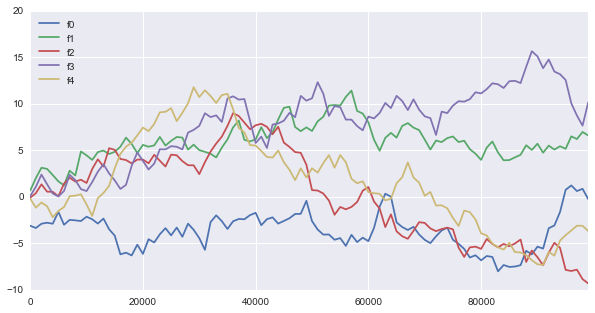

In [91]:
%%time
%matplotlib inline
pd.HDFStore('data.h5')['sql'][::1000].cumsum().plot(figsize=(10, 5))
  # simultaneously reading data from HDF5 store and plotting it

### Cleaning Up

In [92]:
!du -h dat*

976K	data.bcolz/f0/data
8.0K	data.bcolz/f0/meta
988K	data.bcolz/f0
976K	data.bcolz/f1/data
8.0K	data.bcolz/f1/meta
988K	data.bcolz/f1
972K	data.bcolz/f2/data
8.0K	data.bcolz/f2/meta
984K	data.bcolz/f2
976K	data.bcolz/f3/data
8.0K	data.bcolz/f3/meta
988K	data.bcolz/f3
976K	data.bcolz/f4/data
8.0K	data.bcolz/f4/meta
988K	data.bcolz/f4
4.8M	data.bcolz
7.2M	data.csv
4.6M	data.h5
5.2M	data.sql


In [93]:
!ls -n dat*.*

-rw-r--r--  1 501  20  7579503 Nov 19 17:47 data.csv
-rw-r--r--  1 501  20  4807208 Nov 19 17:47 data.h5
-rw-r--r--  1 501  20  5444608 Nov 19 17:47 data.sql

data.bcolz:
total 16
-rw-r--r--  1 501  20    3 Nov 19 17:47 __attrs__
-rw-r--r--  1 501  20   42 Nov 19 17:47 __rootdirs__
drwxr-xr-x  5 501  20  170 Nov 19 17:47 f0
drwxr-xr-x  5 501  20  170 Nov 19 17:47 f1
drwxr-xr-x  5 501  20  170 Nov 19 17:47 f2
drwxr-xr-x  5 501  20  170 Nov 19 17:47 f3
drwxr-xr-x  5 501  20  170 Nov 19 17:47 f4


In [94]:
# cleaning up
!rm -r dat*.*

## Conclusion

**High performance (hardware-bound) I/O operations and highly efficient data blending and analytics are among Python's key strengths.**

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@pqp.io">team@tpq.io</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**datapark.io** |
<a href="http://datapark.io">http://datapark.io</a>

**Python for Finance** |
<a href="http://python-for-finance.com" target="_blank">Python for Finance @ O'Reilly</a>

**Derivatives Analytics with Python** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>